In [2]:
import numpy as np
import _pickle as cPickle
import os
import gzip

# First exercise: Classifying MNIST with MLPs
In this exercise you will implement a Neural Network (or MLP) and classify the MNIST digits with it.
MNIST is a "well hung" dataset that has been used a lot over the years to benchmark different classification algorithms. 
To learn more about it have a look here: http://yann.lecun.com/exdb/mnist/ .

# Data Loading
We first define a function for downloading and loading MNIST.
**WARNING**: Executing it will obviously use up some space on your machine ;). 

In [3]:
def mnist(datasets_dir='./data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
        print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

    print('... loading data')
    # Load the dataset
    f = gzip.open(data_file, 'rb')
    try:
        train_set, valid_set, test_set = cPickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = cPickle.load(f)
    f.close()

    test_x, test_y = test_set
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 1, 28, 28)
    test_y = test_y.astype('int32')
    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 1, 28, 28)
    valid_y = valid_y.astype('int32')
    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 1, 28, 28)
    train_y = train_y.astype('int32')
    rval = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
    print('... done loading data')
    return rval

# Neural Network Layers
We now define "bare bone" neural network layers.
The parts marked with **TODO** are where you should finish the implementation!
Conceptually we will implement the layers as follows:

Each layer has a constructor that takes an input layer plus some additional arguments such as layer size and the activation function name. The layer then uses the provided input layer to compute the layer dimensions, weight shapes, etc. and setup all auxilliary variables.

Each layer then has to provide three functions (as defined in the Layer class below): *output_shape()*, *fprop()* and *brop()*. The output_shape function is used to figure out the shape for the next layer and the *fprop()/bprop()* functions are used to compute forward and backward passes through the network.

In [4]:
# start by defining simple helpers
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def sigmoid_d(x):
    # TODO ################
    # TODO: implement this!
    # TODO ################
    x = sigmoid(x)*(1-sigmoid(x))
    return x

def tanh(x):
    return np.tanh(x)

def tanh_d(x):
    # TODO ################
    # TODO: implement this!
    # TODO ################
    x = 1-tanh(x)**2
    return x

def relu(x):
    return np.maximum(0.0, x)

def relu_d(x):
    # TODO ################
    # TODO: implement this!
    # TODO ################
    x = np.heaviside(x,0)
    return x

def softmax(x, axis=1):
    # to make the softmax a "safe" operation we will 
    # first subtract the maximum along the specified axis
    # so that np.exp(x) does not blow up!
    # Note that this does not change the output.
    x_max = np.max(x, axis=axis, keepdims=True)
    x_safe = x - x_max
    e_x = np.exp(x_safe)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def one_hot(labels):
    """this creates a one hot encoding from a flat vector:
    i.e. given y = [0,2,1]
     it creates y_one_hot = [[1,0,0], [0,0,1], [0,1,0]]
    """
    classes = np.unique(labels)
    n_classes = classes.size
    one_hot_labels = np.zeros(labels.shape + (n_classes,))
    for c in classes:
        one_hot_labels[labels == c, c] = 1
    return one_hot_labels

def unhot(one_hot_labels):
    """ Invert a one hot encoding, creating a flat vector """
    return np.argmax(one_hot_labels, axis=-1)

# then define an activation function class
class Activation(object):
    
    def __init__(self, tname):
        if tname == 'sigmoid':
            self.act = sigmoid
            self.act_d = sigmoid_d
        elif tname == 'tanh':
            self.act = tanh
            self.act_d = tanh_d
        elif tname == 'relu':
            self.act = relu
            self.act_d = relu_d
        else:
            raise ValueError('Invalid activation function.')
            
    def fprop(self, input):
        # we need to remember the last input
        # so that we can calculate the derivative with respect
        # to it later on
        self.last_input = input
        self.last_output = self.act(input)
        return self.act(input)
    
    def bprop(self, output_grad):
        return output_grad * self.act_d(self.last_input)

# define a base class for layers
class Layer(object):
    
    def fprop(self, input):
        """ Calculate layer output for given input 
            (forward propagation). 
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def bprop(self, output_grad):
        """ Calculate input gradient and gradient 
            with respect to weights and bias (backpropagation). 
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def output_size(self):
        """ Calculate size of this layer's output.
        input_shape[0] is the number of samples in the input.
        input_shape[1:] is the shape of the feature.
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a base class for loss outputs
# an output layer can then simply be derived
# from both Layer and Loss 
class Loss(object):

    def loss(self, output, output_net):
        """ Calculate mean loss given real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def input_grad(self, output, output_net):
        """ Calculate input gradient real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a base class for parameterized things        
class Parameterized(object):
    
    def params(self):
        """ Return parameters (by reference) """
        raise NotImplementedError('This is an interface class, please use a derived instance')
    
    def grad_params(self):
        """ Return accumulated gradient with respect to params. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a container for providing input to the network
class InputLayer(Layer):
    
    def __init__(self, input_shape):
        if not isinstance(input_shape, tuple):
            raise ValueError("InputLayer requires input_shape as a tuple")
        self.input_shape = input_shape

    def output_size(self):
        return self.input_shape
    
    def fprop(self, input):
        self.input = input
        return input
    
    def bprop(self, output_grad):
        return output_grad
        
class FullyConnectedLayer(Layer, Parameterized):
    """ A standard fully connected hidden layer, as discussed in the lecture.
    """
    
    def __init__(self, input_layer, num_units, 
                 init_stddev, activation_fun=Activation('relu')):
        self.num_units = num_units
        self.activation_fun = activation_fun
        self.input_layer = input_layer
        # the input shape will be of size (batch_size, num_units_prev) 
        # where num_units_prev is the number of units in the input 
        # (previous) layer
        self.input_shape = input_layer.output_size()
        # TODO ################################
        # TODO: implement weight initialization
        # TODO ################################
        # this is the weight matrix it should have shape: (num_units_prev, num_units)
        self.W = init_stddev*np.random.randn(self.input_shape[1], self.num_units)  #FIXME
        # and this is the bias vector of shape: (num_units)
        self.b = np.zeros((1,self.num_units))  #FIXME
        # create dummy variables for parameter gradients
        # no need to change these here!
        self.dW = None
        self.db = None
    
    def output_size(self):
        return (self.input_shape[0], self.num_units)
    
    def fprop(self, input):
        # TODO ################################################
        # TODO: implement forward propagation
        # NOTE: you should also handle the case were 
        #       activation_fun is None (meaning no activation)
        #       then this is simply a linear layer
        # TODO ###############################################
        # you again want to cache the last_input for the bprop
        # implementation below!
        # x oder z!!!
        self.last_input = input
        
        a = np.dot(input, self.W) + self.b
        if self.activation_fun is None:
            return a
        else:
            return self.activation_fun.fprop(a)
        # NOTE: Use numpy dot product
        # h = t(a), a = W * x + b 
            
        #FIXME
        #raise NotImplementedError("You should implement this!")
        #return np.zeros(self.output_size)
    
        # the output gradient wrt the activation                  
    def bprop(self, output_grad):
        """ Calculate input gradient (backpropagation). """
        # TODO ################################
        # TODO: implement backward propagation
        # TODO ###############################
        
        # HINT: you may have to divide dW and db by n
        #       to make gradient checking work 
        #       OR you divide the gradient in the output layer by n
        n = output_grad.shape[0]
        # accumulate gradient wrt. the parameters first
        # we will need to store these to later update
        # the network after a few forward backward passes
        # NOTE: you should also handle the case were 
        #       activation_fun is None (meaning no activation)
        # the gradient wrt. W should be stored as self.dW
        # the gradient wrt. b should be stored as self.db
        # raise NotImplementedError("you should implement this")
        # NOTE: self.dW is also a numpy dot product   
        if self.activation_fun is not None:
            delta = self.activation_fun.bprop(output_grad)
        else:
            delta = output_grad
        self.dW = np.dot(self.last_input.T, delta)  #FIXME
        self.db = delta.sum(axis = 0, keepdims=True) #FIXME
        # the gradient wrt. the input should be calculated here
        grad_input = np.dot(delta, self.W.T)
        return grad_input
        
    def params(self):
        return self.W, self.b

    def grad_params(self):
        return self.dW, self.db

# finally we specify the interface for output layers 
# which are layers that also have a loss function
# we will implement two output layers:
#  a Linear, and Softmax (Logistic Regression) layer
# The difference between output layers and and normal 
# layers is that they will be called to compute the gradient
# of the loss through input_grad(). bprop will never 
# be called on them!
class LinearOutput(Layer, Loss):
    """ A simple linear output layer that  
        uses a squared loss (e.g. should be used for regression)
    """
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1,)
        
    def fprop(self, input):
        return input

    def bprop(self, output_grad):
        raise NotImplementedError(
            'LinearOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):
        # TODO ####################################
        # TODO: implement gradient of squared loss
        # TODO ####################################
        return (1/len(Y))*(Y_pred-Y) #FIXME FIXED

    def loss(self, Y, Y_pred):
        loss = 0.5 * np.square(Y_pred - Y)
        return np.mean(np.sum(loss, axis=1))

class SoftmaxOutput(Layer, Loss):
    """ A softmax output layer that calculates 
        the negative log likelihood as loss
        and should be used for classification.
    """
    
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1,)
    
    def fprop(self, input):
        return softmax(input)
    
    def bprop(self, output_grad):
        raise NotImplementedError(
            'SoftmaxOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):
        # TODO #######################################################
        # TODO: implement gradient of the negative log likelihood loss
        # TODO #######################################################
        # HINT: since this would involve taking the log 
        #       of the softmax (which is np.exp(x)/np.sum(x, axis=1))
        #       this gradient computation can be simplified a lot,
        #       you may find a connection to the LinearOutput layer!
        # return np.zeros_like(Y_pred)
        return (-Y+Y_pred)/len(Y)
                          
    def loss(self, Y, Y_pred):
        # Assume one-hot encoding of Y
        out = Y_pred
        # to make the loss numerically stable 
        # you should add an epsilon in the log ;)
        eps = 1e-10
        # TODO ####################################
        # calculate negative log likelihood
        # TODO ####################################
        # loss = np.zeros_like(out) #FIXME
        loss = -np.log(eps+out)*Y                   
        return np.mean(np.sum(loss, axis=1))
        

# Neural Network class
With all layers in place (and properly implemented by you) we can finally define a neural network.
For our purposes a neural network is simply a collection of layers which we will cycle through and on which we will call fprop and bprop to compute partial derivatives with respect to the input and the parameters.

Pay special attention to the *check_gradients()* function in which you should implement automatic differentiation. This function will become your best friend when checking the correctness of your implementation.

In [85]:
a = np.ndarray([0,2])
print(a)
b = np.array([[2,3]])
for i in range(3):
    a = np.concatenate((a,b))
a

[]


array([[2., 3.],
       [2., 3.],
       [2., 3.]])

In [96]:

class NeuralNetwork:
    """ Our Neural Network container class.
    """
    def __init__(self, layers):
        self.layers = layers
        self.plot_data = np.ndarray([0,3])
        
    def _loss(self, X, Y):
        Y_pred = self.predict(X)
        return self.layers[-1].loss(Y, Y_pred)

    def predict(self, X):
        """ Calculate an output Y for the given input X. """
        # TODO ##########################################
        # TODO: implement forward pass through all layers
        # TODO ##########################################
        # iterate through all layers passing last output to next input
        for layer in self.layers:
            X = layer.fprop(X)
        Y_pred = X

        return Y_pred
    
    def backpropagate(self, Y, Y_pred, upto=0):
        """ Backpropagation of partial derivatives through 
            the complete network up to layer 'upto'
        """
        # Takes last element from list layers and calculates gradient 
        next_grad = self.layers[-1].input_grad(Y, Y_pred)
        # TODO ##########################################
        # TODO: implement backward pass through all layers
        # TODO ##########################################
        for x in range(2,len(self.layers)-upto +1):
            next_grad = self.layers[-x].bprop(next_grad)
        return next_grad
    
    def classification_error(self, X, Y):
        """ Calculate error on the given data 
            assuming they are classes that should be predicted. 
        """
        Y_pred = unhot(self.predict(X))
        error = Y_pred != Y
        return np.mean(error)
    
    def sgd_epoch(self, X, Y, learning_rate, batch_size):
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        for b in range(n_batches):
            # TODO #####################################
            # Implement stochastic gradient descent here
            # TODO #####################################
            # start by extracting a batch from X and Y
            # (you can assume the inputs are already shuffled)
            X_batch = np.array_split(X, n_batches)[b]
            Y_batch = np.array_split(Y, n_batches)[b]
            # TODO: then forward and backward propagation + updates
            # HINT: layer.params() returns parameters *by reference*
            #       so you can easily update in-place
            Y_batch_pred = self.predict(X_batch)
            self.backpropagate(Y_batch,Y_batch_pred)
            for layer in self.layers:
                if isinstance(layer, FullyConnectedLayer):
                    layer.W = layer.params()[0] - learning_rate * layer.grad_params()[0]
                    layer.d = layer.params()[1] - learning_rate * layer.grad_params()[1]
                    
    
    def gd_epoch(self, X, Y, learning_rate):
        # TODO ##################################################
        # Implement batch gradient descent here
        # A few hints:
        #   There are two strategies you can follow:
        #   Either shove the whole dataset throught the network
        #   at once (which can be problematic for large datasets)
        #   or run through it batch wise as in the sgd approach
        #   and accumulate the gradients for all parameters as
        #   you go through the data. Either way you should then
        #   do one gradient step after you went through the
        #   complete dataset!
        # TODO ##################################################
        Y_pred = self.predict(X)
        self.backpropagate(Y,Y_pred)
        for layer in self.layers:
            if isinstance(layer, FullyConnectedLayer):
                layer.W = layer.params()[0] - learning_rate * layer.grad_params()[0]
                layer.d = layer.params()[1] - learning_rate * layer.grad_params()[1]
    
    def train(self, X, Y, X_valid, Y_valid, learning_rate=0.1, max_epochs=100, batch_size=64,
              descent_type="sgd", y_one_hot=True):

        """ Train network on the given data. """
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        if y_one_hot:
            Y_train = one_hot(Y)
            Y_valid_encoded = one_hot(Y_valid)
        else:
            Y_train = Y
            Y_valid_encoded = Y_valid 
        print("... starting training")
        for e in range(max_epochs+1):
            if descent_type == "sgd":
                self.sgd_epoch(X, Y_train, learning_rate, batch_size)
            elif descent_type == "gd":
                self.gd_epoch(X, Y_train, learning_rate)
            else:
                raise NotImplementedError("Unknown gradient descent type {}".format(descent_type))

            # Output error on the training data
            train_loss = self._loss(X, Y_train)
            train_error = self.classification_error(X, Y)
            print('epoch {:.4f}, loss {:.4f}, train error {:.4f}'.format(e, train_loss, train_error))
            # TODO ##################################################
            # compute error on validation data:
            # simply make the function take validation data as input
            # and then compute errors here and print them
            # TODO ##################################################
            validation_error = self.classification_error(X_valid, Y_valid)
            validation_loss = self._loss(X_valid, Y_valid_encoded)
            print('validation loss {:.4f}'.format(validation_loss))
            print('validation error {:.4f}'.format(validation_error))
            #store value touples for plot
            self.plot_data = np.concatenate((self.plot_data,np.array([[train_loss, validation_loss,e]])))
            
    def check_gradients(self, X, Y):
        """ Helper function to test the parameter gradients for
        correctness. """
        for l, layer in enumerate(self.layers):
            # only use Fully connected layers(input layers are not parameterized)
            if isinstance(layer, Parameterized):
                print('checking gradient for layer {}'.format(l))
                for p, param in enumerate(layer.params()):
                    # we iterate through all parameters
                    param_shape = param.shape
                    # define functions for conveniently swapping
                    # out parameters of this specific layer and 
                    # computing loss and gradient with these 
                    # changed parametrs
                    def output_given_params(param_new):
                        """ A function that will compute the output 
                            of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # return computed loss
                        return self._loss(X, Y)

                    def grad_given_params(param_new):
                        """A function that will compute the gradient 
                           of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # Forward propagation through the net
                        Y_pred = self.predict(X)
                        # Backpropagation of partial derivatives
                        self.backpropagate(Y, Y_pred, upto=l)
                        # to match bias b, array b needs to be changed from (1,k)
                        # to (n,k) with same identical row vector
                        return np.ravel(self.layers[l].grad_params()[p])

                    # let the initial parameters be the ones that
                    # are currently placed in the network and flatten them
                    # to a vector for convenient comparisons, printing etc.
                    param_init = np.ravel(np.copy(param))
                    
                    # To debug you network's gradients use scipys
                    # gradient checking!

                    epsilon = 1e-5
                    import scipy.optimize
                    err = scipy.optimize.check_grad(output_given_params, 
                          grad_given_params, param_init) 
                    print('diff scipy {:.2e}'.format(err))
                    assert(err < epsilon)
                    
                    # reset the parameters to their initial values
                    param[:] = np.reshape(param_init, param_shape)

# Gradient Checking
After implementing everything it is always a good idea to setup some layers and perform gradient
checking on random data. **Note** that this is only an example! It is not a useful network architecture ;). We also expect you to play around with this to test all your implemented components.

In [33]:
input_shape = (5, 10)
n_labels = 20
layers = [InputLayer(input_shape)]

layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=15,
                init_stddev=0.1,
                activation_fun=Activation('sigmoid')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=6,
                init_stddev=0.1,
                activation_fun=Activation('tanh')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=n_labels,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(SoftmaxOutput(layers[-1]))
nn = NeuralNetwork(layers)

In [23]:
# create random data
X = np.random.normal(size=input_shape)
# and random labels
Y = np.zeros((input_shape[0], n_labels))
for i in range(Y.shape[0]):
    idx = np.random.randint(n_labels)
    Y[i, idx] = 1

In [24]:
nn.check_gradients(X, Y)

checking gradient for layer 1
diff scipy 3.28e-07
diff scipy 9.13e-08
checking gradient for layer 2
diff scipy 2.41e-07
diff scipy 8.65e-08
checking gradient for layer 3
diff scipy 2.08e-07
diff scipy 8.24e-08


# Training on MNIST
Finally we can let our network run on the MNIST dataset!

First load the data and reshape it.

In [41]:
# load
Dtrain, Dval, Dtest = mnist()
X_train, y_train = Dtrain
X_valid, y_valid = Dval
X_test, y_test = Dtest

... loading data
... done loading data


*Dtrain* contains 50k images which are of size 28 x 28 pixels. Hence:

In [46]:
print("X_train shape: {}".format(np.shape(X_train)))
print("y_train shape: {}".format(np.shape(y_train)))

X_train shape: (50000, 1, 28, 28)
y_train shape: (50000,)
y_train shape: (10000, 1, 28, 28)


y_train will automatically be converted in the *train()* function to one_hot encoding.


But we need to reshape X_train, as our Network expects flat vectors of size 28*28 as input!

In [47]:
X_train = X_train.reshape(X_train.shape[0], -1)
print("Reshaped X_train size: {}".format(X_train.shape))
X_valid = X_valid.reshape((X_valid.shape[0], -1))
print("Reshaped X_valid size: {}".format(X_valid.shape))
X_test = X_test.reshape((X_test.shape[0], -1))
print("Reshaped X_test size: {}".format(X_test.shape))


Reshaped X_train size: (50000, 784)
Reshaped X_valid size: (10000, 784)
Reshaped X_test size: (10000, 784)


Ah, much better ;-)! 

Now we can finally really start training a Network!


I pre-defined a small Network for you below. Again This is not really a good default and will not produce state of the art results. Please play around with this a bit. See how different activation functions and training procedures (gd / sgd) affect the result.

In [97]:
import time

# Setup a small MLP / Neural Network
# we can set the first shape to None here to indicate that
# we will input a variable number inputs to the network
input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=400,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
nn.train(X_train, y_train, X_valid, y_valid, learning_rate=0.2, 
         max_epochs=20, batch_size=50, y_one_hot=True, descent_type="sgd")
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))

... starting training


KeyboardInterrupt: 

# Figure out a reasonable Network that achieves good performance
As the last part of this task, setup a network that works well and gets reasonable accuracy, say ~ 1-3 percent error on the **validation set**. 
Train this network on the complete data and compute the **test error**. 

Visualize the validation loss and training loss for each iteration in a plot, e.g. using matplotlib

In [ ]:
We need to concatenate training and valiation set

In [54]:
X_complete = np.concatenate((X_train, X_valid), axis=0)
print("X_complete shape:",X_complete.shape)
y_complete = np.concatenate((y_train, y_valid), axis=0)
print("y_complete shape:",y_complete.shape)


X_complete shape: (60000, 784)
y_complete shape: (60000,)


In [141]:
import time

# Setup a small MLP / Neural Network
# we can set the first shape to None here to indicate that
# we will input a variable number inputs to the network
input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=400,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
nn.train(X_complete, y_complete, X_test, y_test, learning_rate=0.5, 
         max_epochs=350, batch_size=50, y_one_hot=True, descent_type="gd")
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))

... starting training
epoch 0.0000, loss 2.2820, train error 0.5269
validation loss 2.2813
validation error 0.5155
epoch 1.0000, loss 2.2624, train error 0.4323
validation loss 2.2613
validation error 0.4186
epoch 2.0000, loss 2.2371, train error 0.3955
validation loss 2.2355
validation error 0.3808
epoch 3.0000, loss 2.2030, train error 0.3775
validation loss 2.2007
validation error 0.3632
epoch 4.0000, loss 2.1566, train error 0.3649
validation loss 2.1533
validation error 0.3563
epoch 5.0000, loss 2.0945, train error 0.3502
validation loss 2.0901
validation error 0.3419
epoch 6.0000, loss 2.0138, train error 0.3300
validation loss 2.0078
validation error 0.3215
epoch 7.0000, loss 1.9128, train error 0.3077
validation loss 1.9049
validation error 0.2976
epoch 8.0000, loss 1.7926, train error 0.2905
validation loss 1.7824
validation error 0.2823
epoch 9.0000, loss 1.6584, train error 0.2819
validation loss 1.6457
validation error 0.2739
epoch 10.0000, loss 1.5189, train error 0.2754
v

validation loss 0.3236
validation error 0.0924
epoch 88.0000, loss 0.3370, train error 0.0950
validation loss 0.3226
validation error 0.0909
epoch 89.0000, loss 0.3355, train error 0.0963
validation loss 0.3208
validation error 0.0924
epoch 90.0000, loss 0.3340, train error 0.0945
validation loss 0.3198
validation error 0.0900
epoch 91.0000, loss 0.3326, train error 0.0953
validation loss 0.3181
validation error 0.0913
epoch 92.0000, loss 0.3313, train error 0.0936
validation loss 0.3171
validation error 0.0893
epoch 93.0000, loss 0.3299, train error 0.0945
validation loss 0.3157
validation error 0.0901
epoch 94.0000, loss 0.3286, train error 0.0927
validation loss 0.3147
validation error 0.0891
epoch 95.0000, loss 0.3274, train error 0.0937
validation loss 0.3133
validation error 0.0894
epoch 96.0000, loss 0.3261, train error 0.0924
validation loss 0.3123
validation error 0.0889
epoch 97.0000, loss 0.3249, train error 0.0929
validation loss 0.3111
validation error 0.0890
epoch 98.0000

epoch 174.0000, loss 0.2614, train error 0.0741
validation loss 0.2533
validation error 0.0715
epoch 175.0000, loss 0.2608, train error 0.0739
validation loss 0.2528
validation error 0.0715
epoch 176.0000, loss 0.2602, train error 0.0738
validation loss 0.2522
validation error 0.0713
epoch 177.0000, loss 0.2595, train error 0.0736
validation loss 0.2516
validation error 0.0710
epoch 178.0000, loss 0.2589, train error 0.0734
validation loss 0.2511
validation error 0.0709
epoch 179.0000, loss 0.2583, train error 0.0732
validation loss 0.2505
validation error 0.0707
epoch 180.0000, loss 0.2577, train error 0.0729
validation loss 0.2499
validation error 0.0702
epoch 181.0000, loss 0.2571, train error 0.0727
validation loss 0.2494
validation error 0.0702
epoch 182.0000, loss 0.2565, train error 0.0726
validation loss 0.2488
validation error 0.0701
epoch 183.0000, loss 0.2558, train error 0.0724
validation loss 0.2483
validation error 0.0698
epoch 184.0000, loss 0.2552, train error 0.0721
va

validation loss 0.2126
validation error 0.0587
epoch 261.0000, loss 0.2163, train error 0.0610
validation loss 0.2122
validation error 0.0585
epoch 262.0000, loss 0.2159, train error 0.0609
validation loss 0.2118
validation error 0.0584
epoch 263.0000, loss 0.2155, train error 0.0608
validation loss 0.2114
validation error 0.0584
epoch 264.0000, loss 0.2151, train error 0.0606
validation loss 0.2110
validation error 0.0583
epoch 265.0000, loss 0.2147, train error 0.0605
validation loss 0.2106
validation error 0.0583
epoch 266.0000, loss 0.2142, train error 0.0604
validation loss 0.2102
validation error 0.0583
epoch 267.0000, loss 0.2138, train error 0.0602
validation loss 0.2099
validation error 0.0580
epoch 268.0000, loss 0.2134, train error 0.0600
validation loss 0.2095
validation error 0.0581
epoch 269.0000, loss 0.2130, train error 0.0599
validation loss 0.2091
validation error 0.0580
epoch 270.0000, loss 0.2126, train error 0.0599
validation loss 0.2087
validation error 0.0580
epo

epoch 347.0000, loss 0.1851, train error 0.0522
validation loss 0.1837
validation error 0.0506
epoch 348.0000, loss 0.1848, train error 0.0520
validation loss 0.1835
validation error 0.0505
epoch 349.0000, loss 0.1845, train error 0.0519
validation loss 0.1832
validation error 0.0504
epoch 350.0000, loss 0.1842, train error 0.0518
validation loss 0.1829
validation error 0.0502
Duration: 3489.1s


In [126]:
print(nn.plot_data)
nn.plot_data[:,0]

[[0.18234289 0.18358888 0.        ]
 [0.11170035 0.11936705 1.        ]]


array([0.18234289, 0.11170035])

In [100]:
# add plotlib
import matplotlib.pyplot as plt

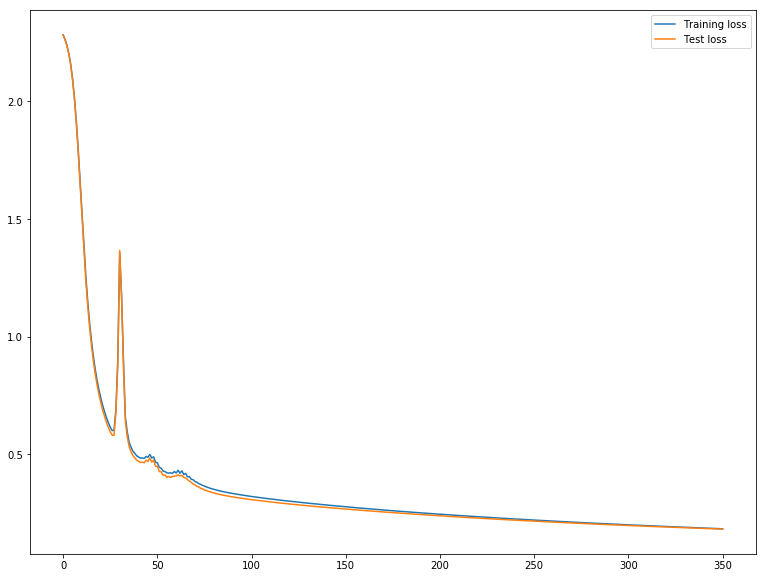

In [142]:
#plot data
#EXAMPLE1
#complete, y_complete, X_test, y_test, learning_rate=0.2, 
#max_epochs=50, batch_size=50, y_one_hot=True, descent_type="sgd"
example1=nn.plot_data
plt.figure(figsize=(13, 10))
plt.plot(example1[:,0], label="Training loss")
plt.plot(example1[:,1], label="Test loss")
plt.legend(loc="best")

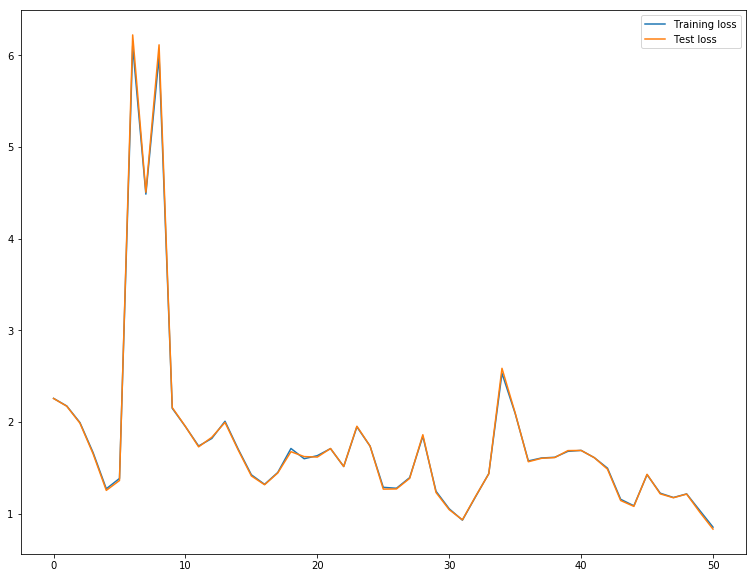

In [133]:
#plot data
#EXAMPLE1
example2=nn.plot_data
plt.figure(figsize=(13, 10))
plt.plot(example2[:,0], label="Training loss")
plt.plot(example2[:,1], label="Test loss")
plt.legend(loc="best")